In [1]:
import xgboost as xgb
import pandas as pd
import sklearn
import numpy as np
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [2]:
path1=("MSFT_prices_1m.csv")
msft=pd.read_csv(path1, index_col="Datetime", parse_dates=True, infer_datetime_format=True)
msft

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-01-07 09:30:00-05:00,314.15,315.00,313.55,314.52,314.52,1266090
2022-01-07 09:31:00-05:00,314.51,315.32,314.33,315.24,315.24,177362
2022-01-07 09:32:00-05:00,315.24,315.28,314.06,314.66,314.66,113985
2022-01-07 09:33:00-05:00,313.50,313.68,313.27,313.56,313.56,112925
2022-01-07 09:34:00-05:00,313.54,314.14,313.26,313.47,313.47,78540
...,...,...,...,...,...,...
2022-01-18 15:56:00-05:00,302.20,302.40,302.06,302.23,302.23,230814
2022-01-18 15:57:00-05:00,302.21,302.82,302.17,302.63,302.63,249918
2022-01-18 15:58:00-05:00,302.54,302.69,302.42,302.60,302.60,264540


In [3]:
# Select the start of the training period
training_begin = msft.index.min()

# Display the training begin date
print(training_begin)

2022-01-07 09:30:00-05:00


In [4]:
# Select the ending period for the training data with an offset of 3 months
training_end = msft.index.min() + DateOffset(minutes=2500)

# Display the training end date
print(training_end)

2022-01-09 03:10:00-05:00


In [5]:
X_train = msft.loc[training_begin:training_end]
X_train = X_train.drop(columns=["Close"])                   
y_train = msft.loc[training_begin:training_end]
y_train = y_train.drop(columns=["Open","High","Low","Adj Close","Volume"])

In [6]:
# Generate the X_test and y_test DataFrames
X_test1 = msft.loc[training_end:]
X_test = X_test1.drop(columns=["Close"])
y_test = msft.loc[training_end:]
y_test = y_test.drop(columns=["Open","High","Low","Adj Close","Volume"])

# Display sample data
X_test


,Open,High,Low,Adj Close,Volume
Datetime,,,,,
2022-01-10 09:30:00-05:00,309.48,309.87,308.55,309.45,1675793
2022-01-10 09:31:00-05:00,309.40,310.01,308.82,309.42,267799
2022-01-10 09:32:00-05:00,309.35,309.35,308.51,308.69,209162
2022-01-10 09:33:00-05:00,308.73,309.17,308.24,308.38,233834
2022-01-10 09:34:00-05:00,308.00,308.48,307.84,308.48,302050
...,...,...,...,...,...
2022-01-18 15:56:00-05:00,302.20,302.40,302.06,302.23,230814
2022-01-18 15:57:00-05:00,302.21,302.82,302.17,302.63,249918
2022-01-18 15:58:00-05:00,302.54,302.69,302.42,302.60,264540


In [7]:
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
# specify parameters via map
from xgboost import XGBRegressor
reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=4000,
    learning_rate=0.091,
    subsample=0.8,
    colsample_bytree=0.8, 
    max_depth=7)

reg_mod.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=.8, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.091, max_delta_step=0, max_depth=7,
             min_child_weight=3, monotone_constraints='()',
             n_estimators=4000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0.005, reg_lambda=.005, scale_pos_weight=1, subsample=0.,
             tree_method='exact', validate_parameters=1, verbosity=None)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.091, max_delta_step=0,
             max_depth=7, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=4000, n_jobs=8,
             num_parallel_tree=1, predictor=None, random_state=0,
             reg_alpha=0.005, reg_lambda=0.005, scale_pos_weight=1,
             subsample=0.0, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [26]:
# make prediction
#preds = bst.predict(dtest)
reg_mod.fit(X_train,y_train)
predictions = reg_mod.predict(X_test)

In [27]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

RMSE: 3.065968


In [28]:
from sklearn.metrics import r2_score
r2 = np.sqrt(r2_score(y_test, predictions))
print("R_Squared Score : %f" % (r2))

R_Squared Score : 0.799531


In [39]:
print(predictions)

[310.28296 310.2831  310.2831  ... 310.2831  310.28296 310.3466 ]


In [40]:
X_test1["Predictions"]=predictions
xgb_pred=X_test1
xgb_pred

C:\Users\brand\AppData\Local\Temp/ipykernel_12592/2281152618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test1["Predictions"]=predictions


,Open,High,Low,Close,Adj Close,Volume,Predictions,Signal
Datetime,,,,,,,,
2022-01-10 09:30:00-05:00,309.48,309.87,308.55,309.45,309.45,1675793,310.282959,1.0
2022-01-10 09:31:00-05:00,309.40,310.01,308.82,309.42,309.42,267799,310.283112,1.0
2022-01-10 09:32:00-05:00,309.35,309.35,308.51,308.69,308.69,209162,310.283112,1.0
2022-01-10 09:33:00-05:00,308.73,309.17,308.24,308.38,308.38,233834,310.283112,1.0
2022-01-10 09:34:00-05:00,308.00,308.48,307.84,308.48,308.48,302050,310.283112,1.0
...,...,...,...,...,...,...,...,...
2022-01-18 15:56:00-05:00,302.20,302.40,302.06,302.23,302.23,230814,310.283112,1.0
2022-01-18 15:57:00-05:00,302.21,302.82,302.17,302.63,302.63,249918,310.283112,1.0
2022-01-18 15:58:00-05:00,302.54,302.69,302.42,302.60,302.60,264540,310.283112,1.0


In [41]:
xgb_pred['Signal'] =0.0
xgb_pred.loc[(xgb_pred['Predictions'] > xgb_pred['Close']), 'Signal']=1
xgb_pred.loc[(xgb_pred['Predictions'] < xgb_pred['Close']), 'Signal']=-1
xgb_pred

C:\Users\brand\AppData\Local\Temp/ipykernel_12592/1683302698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgb_pred['Signal'] =0.0
C:\Users\brand\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Open,High,Low,Close,Adj Close,Volume,Predictions,Signal
Datetime,,,,,,,,
2022-01-10 09:30:00-05:00,309.48,309.87,308.55,309.45,309.45,1675793,310.282959,1.0
2022-01-10 09:31:00-05:00,309.40,310.01,308.82,309.42,309.42,267799,310.283112,1.0
2022-01-10 09:32:00-05:00,309.35,309.35,308.51,308.69,308.69,209162,310.283112,1.0
2022-01-10 09:33:00-05:00,308.73,309.17,308.24,308.38,308.38,233834,310.283112,1.0
2022-01-10 09:34:00-05:00,308.00,308.48,307.84,308.48,308.48,302050,310.283112,1.0
...,...,...,...,...,...,...,...,...
2022-01-18 15:56:00-05:00,302.20,302.40,302.06,302.23,302.23,230814,310.283112,1.0
2022-01-18 15:57:00-05:00,302.21,302.82,302.17,302.63,302.63,249918,310.283112,1.0
2022-01-18 15:58:00-05:00,302.54,302.69,302.42,302.60,302.60,264540,310.283112,1.0


In [42]:
xgb_plot=xgb_pred.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Signal'])
xgb_plot

,Close,Predictions
Datetime,,
2022-01-10 09:30:00-05:00,309.45,310.282959
2022-01-10 09:31:00-05:00,309.42,310.283112
2022-01-10 09:32:00-05:00,308.69,310.283112
2022-01-10 09:33:00-05:00,308.38,310.283112
2022-01-10 09:34:00-05:00,308.48,310.283112
...,...,...
2022-01-18 15:56:00-05:00,302.23,310.283112
2022-01-18 15:57:00-05:00,302.63,310.283112
2022-01-18 15:58:00-05:00,302.60,310.283112


<AxesSubplot:xlabel='Datetime'>

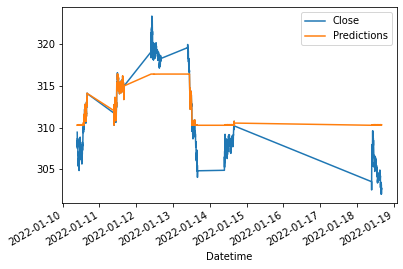

In [43]:
xgb_plot.plot()